In [1]:
'''
Editor: @Hyunhomo
Source: https://github.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy

Load trained model. Then, make test(prediction) and evaluation
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.ensemble import GradientBoostingClassifier

## Load features from csv files
final_feat = pd.read_csv('final_feat.csv')
labeled_features = pd.read_csv('labeled_features.csv')
final_feat['datetime'] = pd.to_datetime(final_feat['datetime'], format="%Y-%m-%d %H:%M:%S")
labeled_features['datetime'] = pd.to_datetime(labeled_features['datetime'], format="%Y-%m-%d %H:%M:%S")

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))


    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))






    







model loaded
test_result         Unnamed: 0  machineID            datetime  voltmean_3h  rotatemean_3h  \
2175          2175          1 2015-10-01 03:00:00   170.301017     449.036995   
2176          2176          1 2015-10-01 06:00:00   165.339972     435.660354   
2177          2177          1 2015-10-01 09:00:00   183.752875     463.058640   
2178          2178          1 2015-10-01 12:00:00   177.866822     506.692032   
2179          2179          1 2015-10-01 15:00:00   167.471524     425.963281   
...            ...        ...                 ...          ...            ...   
290637      290637        100 2015-10-05 09:00:00   188.267556     407.256175   
290638      290638        100 2015-10-05 12:00:00   167.859576     465.992407   
290639      290639        100 2015-10-05 15:00:00   170.348099     434.234744   
290640      290640        100 2015-10-05 18:00:00   152.265370     459.557611   
290641      290641        100 2015-10-05 21:00:00   162.887965     481.415205   

  

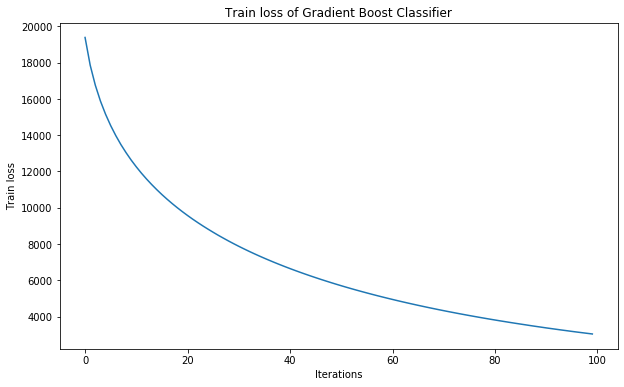

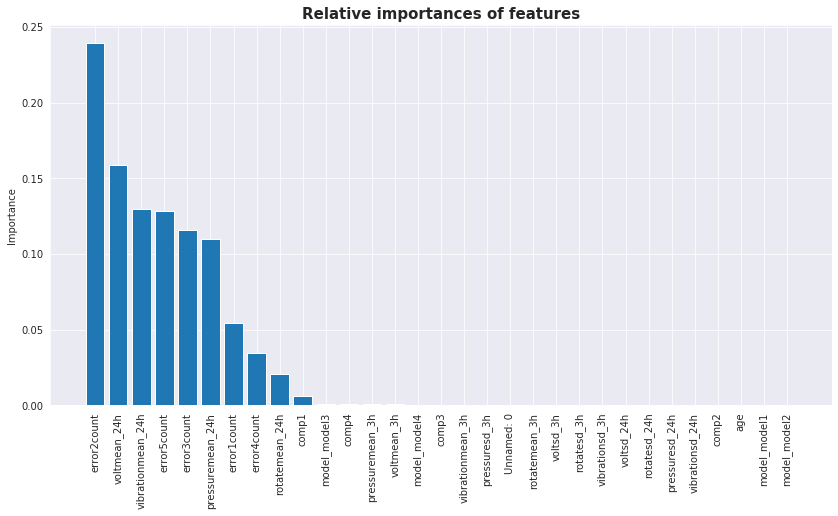

In [2]:
## Load trained model
filename = 'GBC_pdm_model.sav'
my_model = pickle.load(open(filename, 'rb'))
print("model loaded")


## make prediction(test)
test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
test_result['predicted_failure'] = my_model.predict(test_X)
print ("test_result", test_result)
test_results.append(test_result)
models.append(my_model)

##save prediction result to csv file
export_test_csv = test_results[0].to_csv('test_result_GBC.csv')
# test_results = pd.read_csv('test_result_GBC.csv')
train_loss = my_model.train_score_
# print ("train_loss_", train_loss)
# print ("train loss dtype", train_loss.dtype)


## plot training loss curve
plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.title('Train loss of Gradient Boost Classifier')
plt.ylabel('Train loss')
plt.xlabel('Iterations')


sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.title("Relative importances of features", fontdict={'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_importances.png', bbox_inches='tight')



In [3]:
### Evaluation

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis=1)
    cm_col_sums = cm.sum(axis=0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis=1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0, 0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist
    mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist
    mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])

    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist ** 2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df


evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i + 1))
    evaluation_result = Evaluate(actual=test_result['failure'],
                                 predicted=test_result['predicted_failure'],
                                 labels=['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
print (evaluation_results[0])  # show full results for first split only



Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[71719     6     0    10     3]
 [   63   256     0     1     0]
 [    0     2   546     0     0]
 [   34     0     0   189     1]
 [    2     2     3     1   272]]
                                        none     comp1     comp2     comp3  \
accuracy                            0.998249  0.998249  0.998249  0.998249   
precision                           0.998622  0.962406  0.994536  0.940299   
recall                              0.999735  0.800000  0.996350  0.843750   
F1                                  0.999178  0.873720  0.995442  0.889412   
macro precision                     0.976274  0.976274  0.976274  0.976274   
macro recall                        0.922253  0.922253  0.922253  0.922253   
macro F1                            0.947234  0.947234  0.947234  0.947234   
average accuracy                    0.999300  0.999300  0.999300  0.999300   
micro-averaged precision/recall/

my_model.classes_  ['comp1' 'comp2' 'comp3' 'comp4' 'none']
comp comp1

[0 0 0 ... 0 0 0]
unique [0 1]
counts [72790   320]
comp comp2

[0 0 0 ... 0 0 0]
unique [0 1]
counts [72562   548]
comp comp3

[0 0 0 ... 0 0 0]
unique [0 1]
counts [72886   224]
comp comp4

[0 0 0 ... 0 0 0]
unique [0 1]
counts [72830   280]
comp none

[1 1 1 ... 1 1 1]
unique [0 1]
counts [ 1372 71738]


/home/hyunhomo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



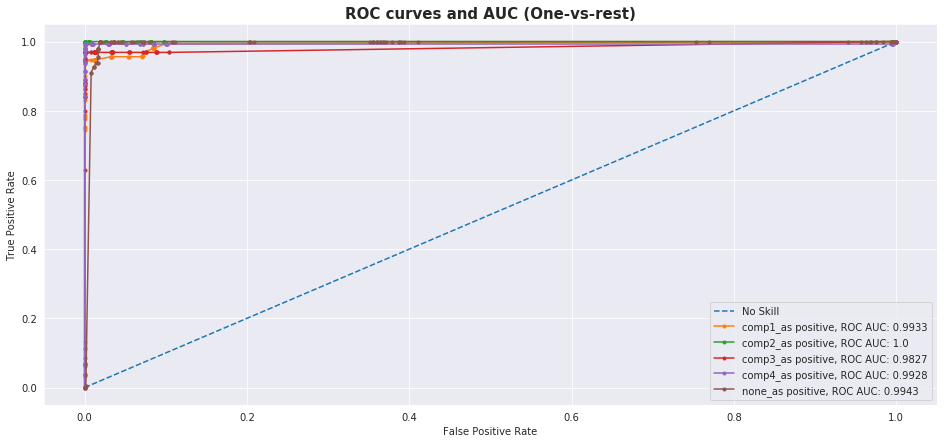

<Figure size 864x432 with 0 Axes>

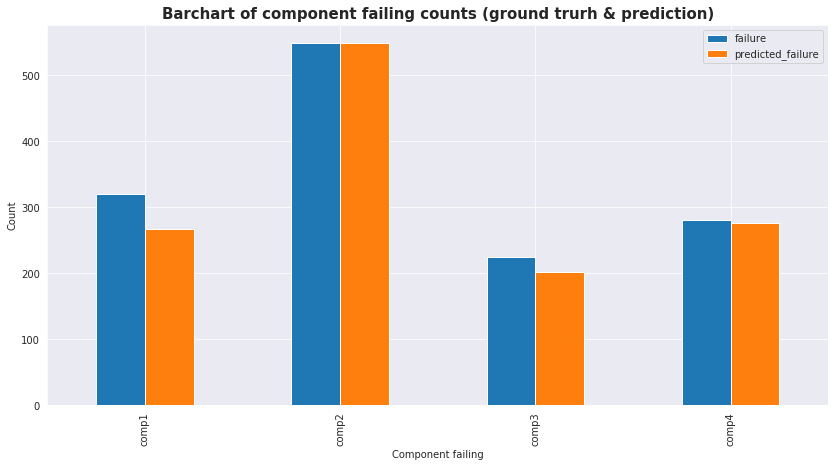

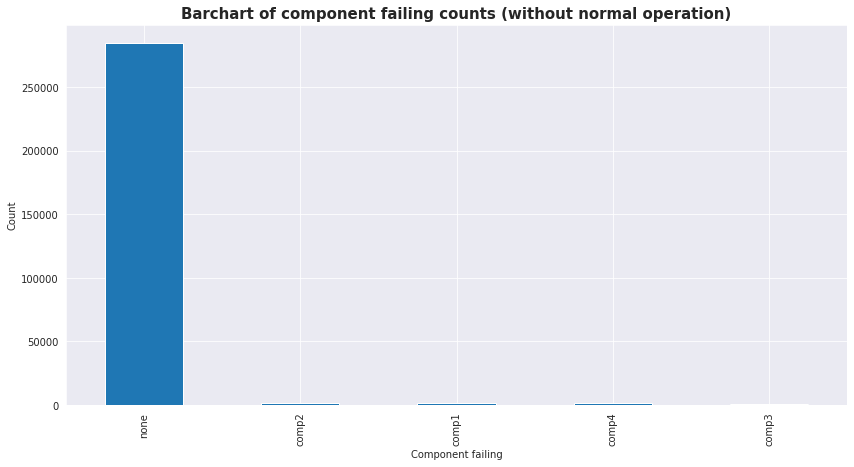

In [4]:
'''
Illustate the result with ROC curves and AUC score
ROC Curve: Plot of False Positive Rate (x) vs. True Positive Rate (y), (fpr, tpr)
TruePositiveRate = TruePositives / (TruePositives + False Negatives)
FalsePositiveRate = FalsePositives / (FalsePositives + TrueNegatives)
'''
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score



# retrieve predict probability (for 5 multiclass)
proba_array = my_model.predict_proba(test_X)
# convert pandas dataseries of ground truth to numpy array
truth_array = test_result['failure'].to_numpy()

# temporal array (same shape to ground truth array)
truth_array_temp =  np.zeros(len(truth_array) )
# blank python lisst to append each truth array
testy_bi = []

# classes_ attribute indicates output classes
print("my_model.classes_ ", my_model.classes_ )

# loop for converting categorical data into one-hot encoded binary 
for comp in my_model.classes_ :
    print ("comp", comp)
    print ()
    truth_array_temp[truth_array!=comp]=np.int64(0)
    truth_array_temp[truth_array==comp]=np.int64(1)
    truth_array_temp = np.int64(truth_array_temp)
    print (truth_array_temp)
    unique, counts = np.unique(truth_array_temp, return_counts=True)
    print ("unique", unique)
    print("counts",counts)
    testy_bi.append(truth_array_temp)
    truth_array_temp =  np.zeros(len(truth_array) )


    
    
plt.figure(figsize=(16,7))
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# loop for each class (i.e., iteration for each type of failure)
for idx in range(len(my_model.classes_)):
    # retrieve just the probabilities for the positive class
    # calculate roc curve for model
    fpr, tpr, thres_roc = roc_curve(testy_bi[idx], proba_array[:,idx])
#     print ("thres_roc", thres_roc)
    # calculate ROC AUC
    roc_auc = roc_auc_score(testy_bi[idx], proba_array[:,idx])
    roc_auc = np.around(roc_auc, decimals=4)
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label=my_model.classes_[idx] + '_as positive, ' + 'ROC AUC: ' + str(roc_auc))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
plt.title("ROC curves and AUC (One-vs-rest)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('ROC_AUC.png', bbox_inches='tight')



## Draw the barchart of component failing(ground trurh & prediction)
plt.figure(figsize=(12, 6))
counts_failures = test_result['failure'].value_counts().drop('none')
counts_pd_failures = test_result['predicted_failure'].value_counts().drop('none')
counts = pd.concat([counts_failures,counts_pd_failures],axis=1)
# print ("counts", counts )
sns.set_style("darkgrid")
ax = counts.plot(kind='bar', legend='true')
fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (ground trurh & prediction)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth.png', bbox_inches='tight')


## Draw the barchart of component failing(ground trurh)
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')
plt.title("Barchart of component failing counts (without normal operation)" , fontdict = {'fontsize':15, 'fontweight':'bold'})
plt.savefig('barchart_truth(w none).png', bbox_inches='tight')



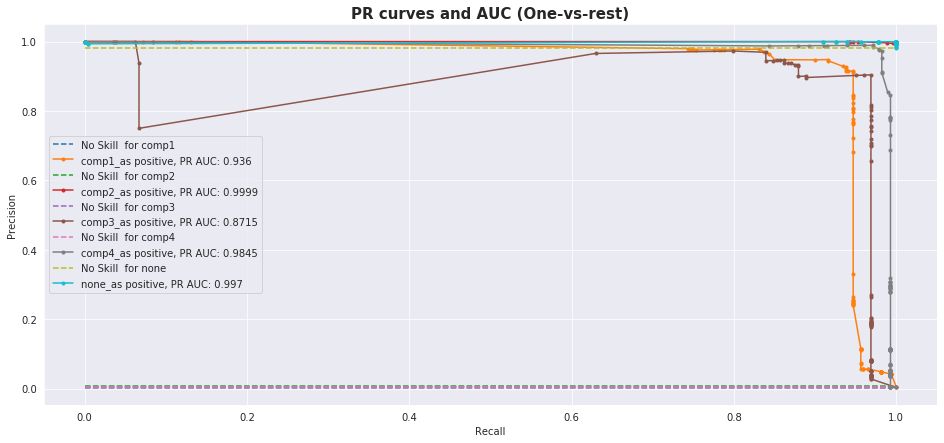

In [5]:
'''
Precision-Recall Curves and AUC
Precision-Recall(PR) Curve: Plot of Recall (x) vs Precision (y).
Precision = TruePositives / (TruePositives + FalsePositives)
Recall = TruePositives / (TruePositives + FalseNegatives)

'''
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc



plt.figure(figsize=(16,7))

# loop for each class (i.e., iteration for each type of failure)
for idx in range(len(my_model.classes_)):
    test_y_bi_temp = testy_bi[idx]
    no_skill = len(test_y_bi_temp[test_y_bi_temp==1]) / len(test_y_bi_temp)
    # plot no skill PR curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill '+' for '+my_model.classes_[idx])
    
    # retrieve just the probabilities for the positive class
    # calculate PR for model
    precision, recall, _ = precision_recall_curve(testy_bi[idx], proba_array[:,idx])
#     print ("thres_roc", thres_roc)
    # calculate PR AUC
    auc_score = auc(recall, precision)
    auc_score = np.around(auc_score, decimals=4)
    # plot model PR curve
    plt.plot(recall, precision, marker='.', label=my_model.classes_[idx] + '_as positive, ' + 'PR AUC: ' + str(auc_score))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
plt.title("PR curves and AUC (One-vs-rest)" , fontdict = {'fontsize':15, 'fontweight':'bold'})    
plt.savefig("PR_AUC.png", bbox_inches='tight')